### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 17th at 11.59pm CST
---

## Only one problem this week

This problem is mostly about generative classification, but will include one discriminative classifer that we'll meet in `Lecture_20`.

1. Use the following code snippet to read in SDSS galaxy color data.
```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```
This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

### Solution

### 1. Use the following code snippet to read in SDSS galaxy color data.
```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```
This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats
from scipy.stats import laplace

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
import time
from astroML.datasets import fetch_sdss_galaxy_colors
import matplotlib

In [2]:
data = fetch_sdss_galaxy_colors()
data_df = pd.DataFrame(data)
print('Data column names ' , data_df.columns )
data_df.head

Data column names  Index(['u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err'], dtype='object')


<bound method NDFrame.head of               u         g         r         i         z specClass  redshift  \
0      18.35314  17.86316  17.70989  17.83738  17.66104       QSO  0.757869   
1      18.70238  18.40013  18.19013  17.87871  17.79026       QSO  1.855482   
2      19.31894  17.79539  17.21980  16.96614  16.86262    GALAXY  0.000000   
3      18.79420  17.53207  16.93394  16.50100  16.25197    GALAXY  0.057497   
4      19.11163  17.66049  16.90813  16.47642  16.22423    GALAXY  0.072000   
...         ...       ...       ...       ...       ...       ...       ...   
49995  19.37421  17.58219  16.64660  16.17092  15.83113    GALAXY  0.117753   
49996  17.71214  16.45024  15.83712  15.43995  15.19268    GALAXY  0.060156   
49997  19.30764  17.99605  17.51226  17.21298  17.00362    GALAXY  0.089600   
49998  19.41548  18.13206  17.43758  17.05745  16.80801    GALAXY  0.110559   
49999  19.28877  17.82239  17.13275  16.75485  16.47923    GALAXY  0.074065   

       redshift_err  

In [3]:
u_g_color = data_df['u'] - data_df['g']
g_r_color = data_df['g'] - data_df['r']
r_i_color = data_df['r'] - data_df['i']
i_z_color = data_df['i'] - data_df['z']

spectral_c = data_df['specClass']
redshift = data_df['redshift']

In [4]:
uniq_spec_class = np.unique(spectral_c)
uniq_spec_class

array(['GALAXY', 'QSO'], dtype=object)

In [5]:
data_df.pivot_table(index=['specClass'], aggfunc='size')

specClass
GALAXY    42799
QSO        7201
dtype: int64

In [6]:
u_g_color
[np.where(spectral_c == uniq_spec_class[1])]

[(array([    0,     1,     5, ..., 49974, 49978, 49989]),)]

### 2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.

In [7]:
u_g_color = (data_df['u'] - data_df['g']).to_numpy()
g_r_color = (data_df['g'] - data_df['r']).to_numpy()
r_i_color = (data_df['r'] - data_df['i']).to_numpy()
i_z_color = (data_df['i'] - data_df['z']).to_numpy()

spectral_c = (data_df['specClass']).to_numpy()
redshift = (data_df['redshift']).to_numpy()

In [8]:
u_g_color[np.where(spectral_c == uniq_spec_class[1])]

array([0.48998, 0.30225, 0.44309, ..., 0.79039, 0.17806, 0.40555])

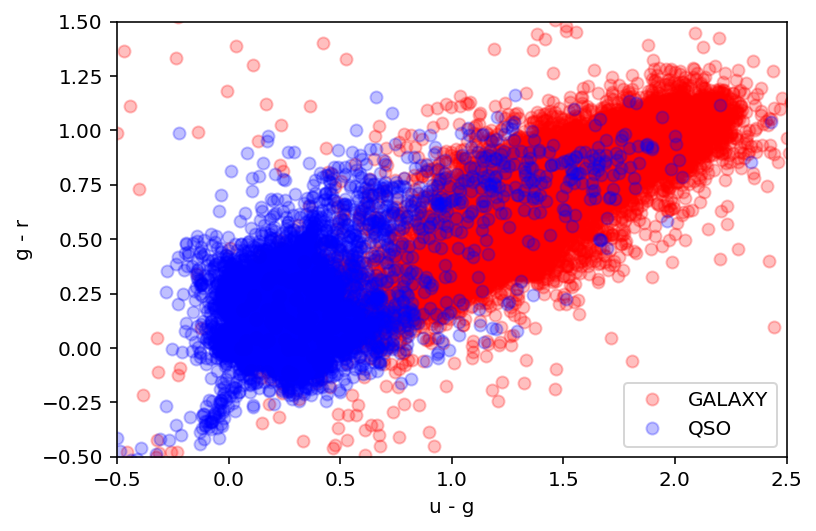

In [9]:
plt.plot(u_g_color[np.where(spectral_c == uniq_spec_class[0])],
         g_r_color[np.where(spectral_c == uniq_spec_class[0])],
         label =  uniq_spec_class[0], marker = 'o', linestyle = 'None',  color = 'red', alpha = 0.25 )

plt.plot(u_g_color[np.where(spectral_c == uniq_spec_class[1])],
         g_r_color[np.where(spectral_c == uniq_spec_class[1])],
         label =  uniq_spec_class[1], marker = 'o', linestyle = 'None',  color = 'blue', alpha = 0.25)

plt.xlabel('u - g')
plt.ylabel('g - r')
plt.xlim([-0.5, 2.5])
plt.ylim([-0.5, 1.5])
plt.legend(loc='lower right')


In [10]:
''' Need to run cell bellow to work y = [0,1... ] where 0 galaxy and 1 is QSO
plt.scatter(u_g_color, 
         g_r_color,
         c = y, s=50, cmap='spring' ,edgecolor='k' , alpha = 0.25)
plt.xlim([-0.45, 2.55])
plt.ylim([-0.45, 1.55])
'''

" Need to run cell bellow to work y = [0,1... ] where 0 galaxy and 1 is QSO\nplt.scatter(u_g_color, \n         g_r_color,\n         c = y, s=50, cmap='spring' ,edgecolor='k' , alpha = 0.25)\nplt.xlim([-0.45, 2.55])\nplt.ylim([-0.45, 1.55])\n"

In [11]:
#y

3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.

In [12]:
X = np.array([u_g_color , g_r_color , r_i_color , i_z_color, redshift]).T
y = np.zeros(len(spectral_c))
y[np.where(spectral_c == uniq_spec_class[1])] = 1 
X.shape[1]

5

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2)

4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*

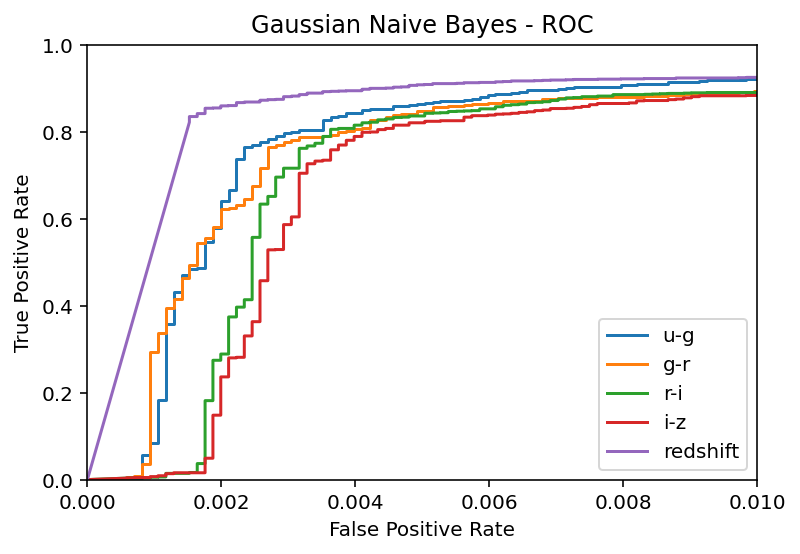

In [14]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve

legend_labels=['u-g','g-r','r-i','i-z','redshift']

for index in range(0, (X.shape[1])):
    #print(index)
    GN_Bayes = GaussianNB() # model
    GN_Bayes.fit(X_train[:, : index+1], y_train) #training data 
    y_pred = GN_Bayes.predict_proba(X_test[:, : index+1])
    q_prob = y_pred[:,1]
    
    fpr, tpr, threshold = roc_curve(y_test, q_prob)
    
    plt.plot(fpr,tpr,label=legend_labels[index])
    
plt.axis([0,0.01,0,1])
plt.title('Gaussian Naive Bayes - ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.show()
    

In [15]:
#GN_Bayes.classes_

5. Repeat (4) for Quadratic Discriminant Analysis. 

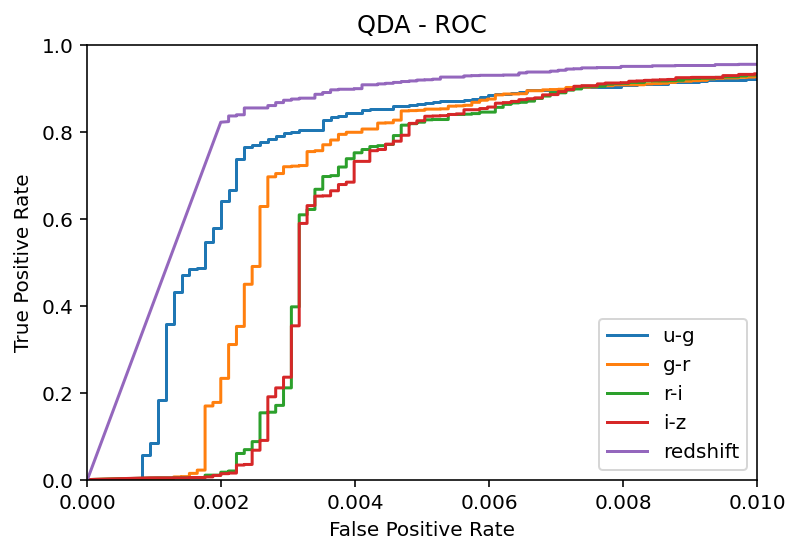

In [16]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

legend_labels=['u-g','g-r','r-i','i-z','redshift']

for index0 in range(0, (X.shape[1])):
    #print(index)
    qda_model = QuadraticDiscriminantAnalysis() # model
    qda_model.fit(X_train[:, : index0+1], y_train) #training data 
    y_pred = qda_model.predict_proba(X_test[:, : index0+1])
    q_prob = y_pred[:,1]
    
    fpr, tpr, threshold = roc_curve(y_test, q_prob)
    
    plt.plot(fpr,tpr,label=legend_labels[index0])
    
plt.axis([0,0.01,0,1])
plt.title('QDA - ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')




6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.

In [17]:
X_color = np.array([u_g_color , g_r_color , r_i_color , i_z_color]).T
n_comp = 10 

X_train_color, X_test_color, y_train_color, y_test_color  = train_test_split(X_color, y, test_size=0.2)

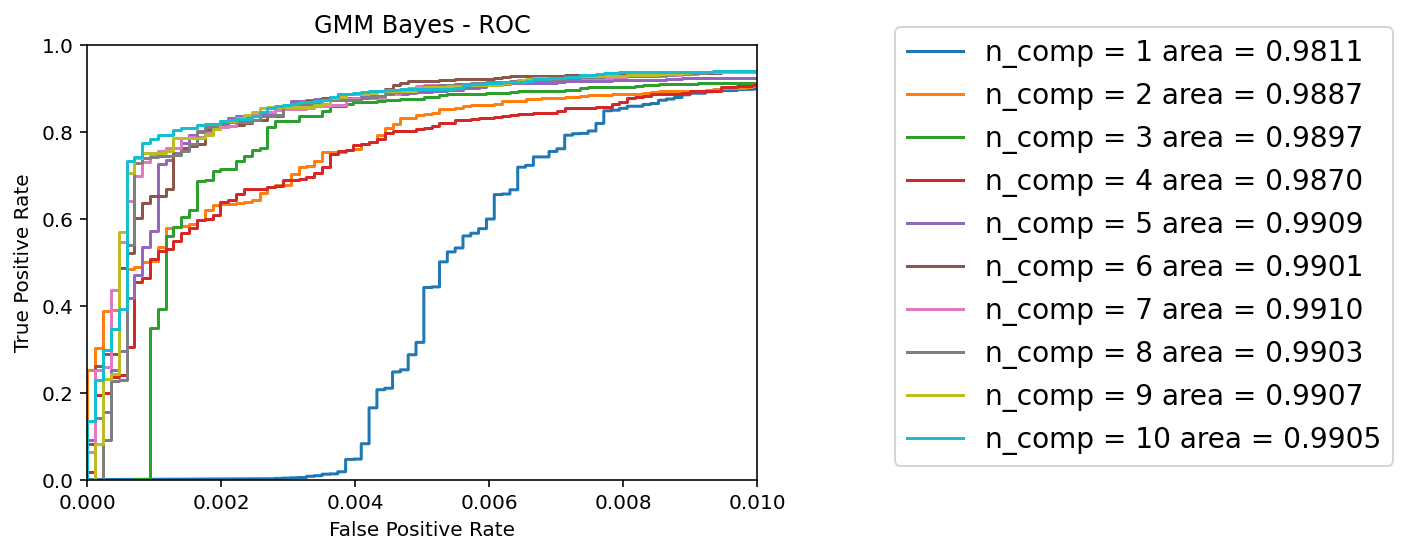

In [18]:
from astroML.classification import GMMBayes
from scipy.integrate import trapz

area_gmm_b = np.array([])
n_comp_array = np.arange(1,11,1)

for index2 in range(0,n_comp):
    #print(index2)
    GMM_B_model = GMMBayes(n_components=n_comp_array[index2])
    GMM_B_model.fit(X_train_color, y_train_color)
    y_pred_color = GMM_B_model.predict_proba(X_test_color)
    q_prob_color = y_pred_color[:,1]
    
    fpr, tpr, threshold = roc_curve(y_test_color, q_prob_color)
    
    area_under_roc=trapz(y=tpr,x=fpr)
    area_gmm_b = np.append(area_gmm_b, area_under_roc )

    
    plt.plot(fpr,tpr, label='n_comp = {:.0f}'.format(n_comp_array[index2]) + ' area = {:.4f}'.format(area_under_roc))
    

plt.axis([0,0.01,0,1])
plt.title('GMM Bayes - ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', bbox_to_anchor=(1.97, 0), fontsize=14)

    

The 'best' performace was using 7 components since it has the largest area under the ROC. (However, all are really close with 99%) 

In [19]:
#X_test_color

In [20]:
np.where(area_gmm_b.max())

(array([0]),)

In [21]:
index_best_gmm_b = np.where(area_gmm_b == area_gmm_b.max())
n_comp_array[index_best_gmm_b]

array([7])

In [22]:
area_gmm_b

array([0.98109251, 0.98869564, 0.98965856, 0.98696931, 0.9909362 ,
       0.99011899, 0.99098831, 0.99031881, 0.9907256 , 0.99051783])

7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 

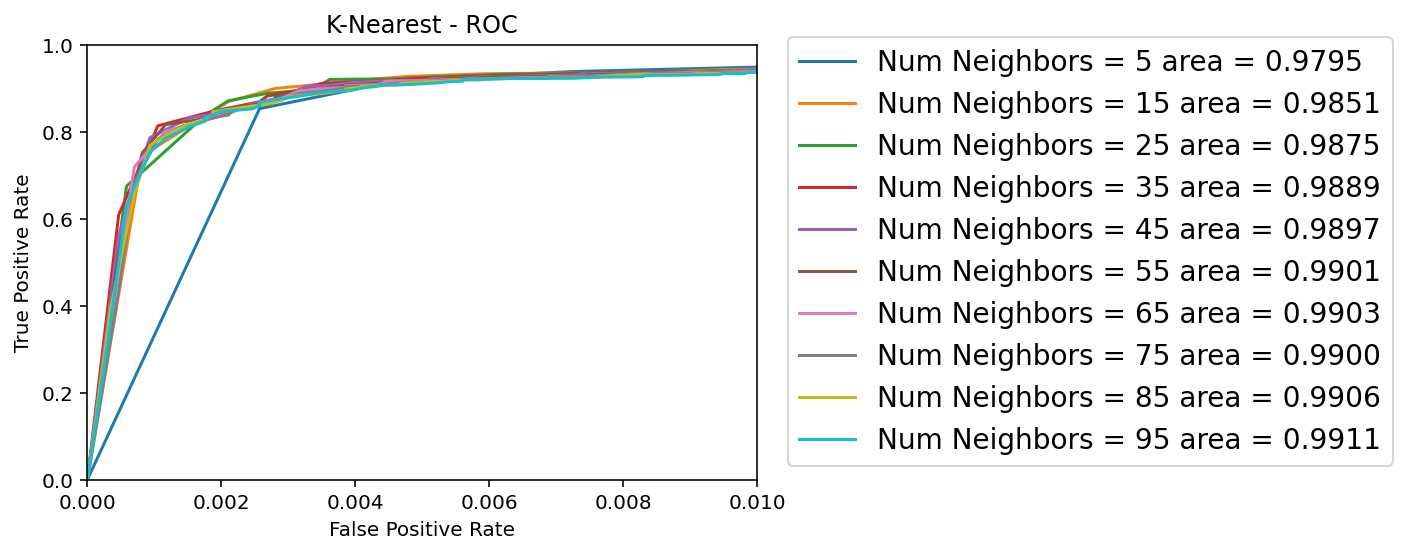

In [23]:
from sklearn.neighbors import KNeighborsClassifier as KNN

NN = np.arange(5,100,10)
#print(NN) # array([ 5, 15, 25, 35, 45, 55, 65, 75, 85, 95])

area_knn = np.array([])


for index3 in range(len(NN)):
    
    knn = KNN(NN[index3])  
    knn.fit(X_train_color, y_train_color)  
    y_pred_color_knn = knn.predict_proba(X_test_color) 
    q_prob_color_knn = y_pred_color_knn[:,1]
    
    fpr, tpr, threshold = roc_curve(y_test_color, q_prob_color_knn)
    
    area_under_roc=trapz(y=tpr,x=fpr)
    area_knn = np.append(area_knn, area_under_roc)
    
    plt.plot(fpr,tpr, label= 'Num Neighbors = {:.0f}'.format(NN[index3]) + ' area = {:.4f}'.format(area_under_roc))


plt.axis([0,0.01,0,1])
plt.title('K-Nearest - ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', bbox_to_anchor=(1.97, 0), fontsize=14)


Between 75 and 85 nearest neighbors will give the best performance of the ROC curves with 0.9938 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 

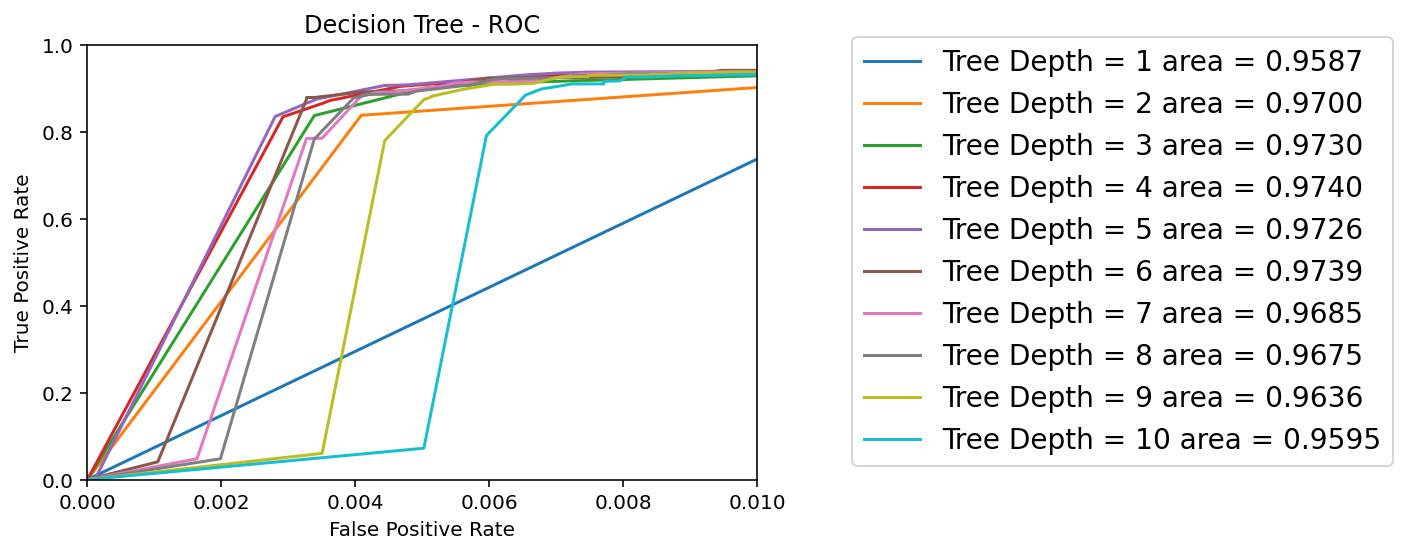

In [24]:
from sklearn.tree import DecisionTreeClassifier as DT

tree_depth = np.arange(1,11,1)
#tree_depth

area_dt = np.array([])

for index4 in range(len(tree_depth)):
    
    d_tree_model = DT(max_depth=tree_depth[index4])  
    d_tree_model.fit(X_train_color, y_train_color)  
    y_pred_color_d_tree = d_tree_model.predict_proba(X_test_color) 
    q_prob_color_d_tree = y_pred_color_d_tree[:,1]
    
    fpr, tpr, threshold = roc_curve(y_test_color, q_prob_color_d_tree)
    
    area_under_roc=trapz(y=tpr,x=fpr)
    area_dt = np.append(area_dt, area_under_roc )
    
    plt.plot(fpr,tpr, label= 'Tree Depth = {:.0f}'.format(tree_depth[index4]) + ' area = {:.4f}'.format(area_under_roc))


plt.axis([0,0.01,0,1])
plt.title('Decision Tree - ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', bbox_to_anchor=(1.97, 0), fontsize=14)



A previous run gave me a best performance has the largest area with a tree depth of 6.


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 

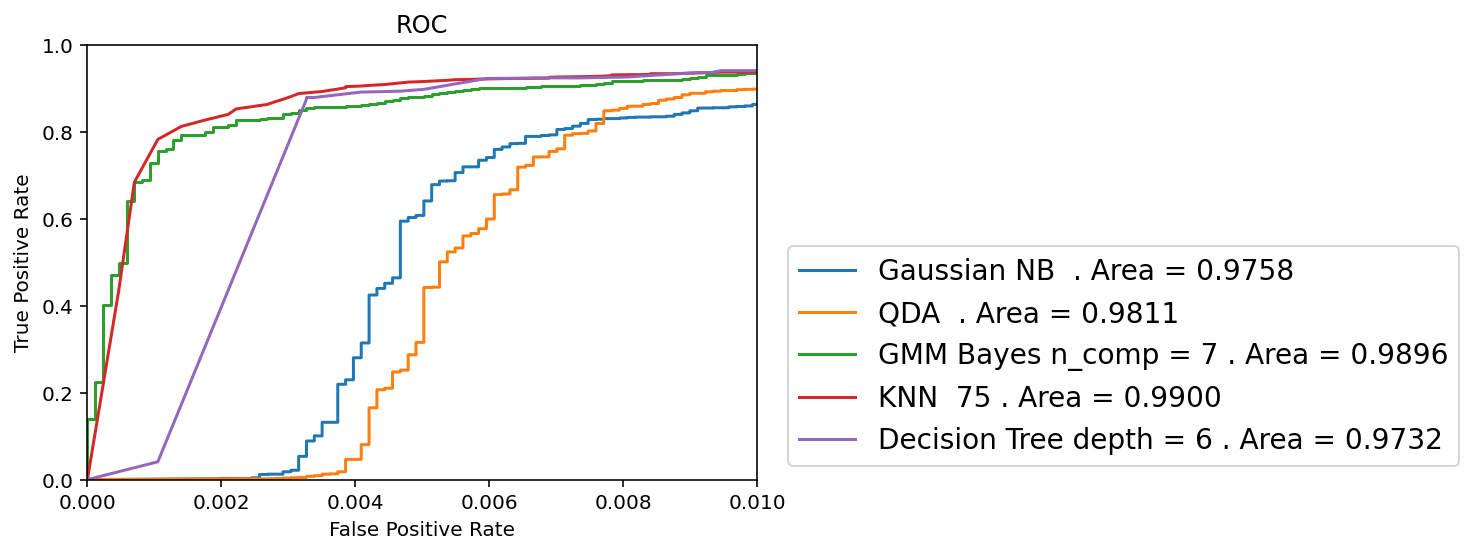

In [25]:

#Best pearmeters for GMMBayes , KNN, DT 

best_n_comp = 7
best_NN = 75
best_depth = 6


# GNB - Gaussian Naive Bayes
GN_Bayes = GaussianNB() # model
GN_Bayes.fit(X_train_color, y_train_color) #training data 
y_pred_BN_Bayes = GN_Bayes.predict_proba(X_test_color)
q_prob_BN_Bayes = y_pred_BN_Bayes[:,1]
    
fpr_GN_Bayes, tpr_GN_Bayes, threshold_GN_Bayes = roc_curve(y_test_color, q_prob_BN_Bayes)
area_under_roc_GN_Bayes=trapz(y=tpr_GN_Bayes,x=fpr_GN_Bayes)
plt.plot(fpr_GN_Bayes,tpr_GN_Bayes, label= 'Gaussian NB ' + ' . Area = {:.4f}'.format(area_under_roc_GN_Bayes))
    
    

# QDA - QuadraticDiscriminantAnalysis
qda_model = QuadraticDiscriminantAnalysis() # model
qda_model.fit(X_train_color, y_train_color) #training data 
y_pred_qda = qda_model.predict_proba(X_test_color)
q_prob_qda = y_pred_qda[:,1]
    
fpr_qda, tpr_qda, threshold_qda = roc_curve(y_test_color, q_prob_qda)
area_under_roc_qda=trapz(y=tpr_qda,x=fpr_qda)
plt.plot(fpr_qda,tpr_qda, label= 'QDA ' + ' . Area = {:.4f}'.format(area_under_roc_qda))
   
    
#GMMBayes
GMM_B_model = GMMBayes(n_components=best_n_comp)
GMM_B_model.fit(X_train_color, y_train_color)
y_pred_color_GMM_B = GMM_B_model.predict_proba(X_test_color)
q_prob_color_GMM_B = y_pred_color_GMM_B[:,1]
    
fpr_GMM_B, tpr_GMM_B, threshold_GMM_B = roc_curve(y_test_color, q_prob_color_GMM_B)
area_under_roc_GMM_B=trapz(y=tpr_GMM_B,x=fpr_GMM_B)
plt.plot(fpr_GMM_B, tpr_GMM_B, label= 'GMM Bayes n_comp = ' + str(best_n_comp) + ' . Area = {:.4f}'.format(area_under_roc_GMM_B))

  
#K Nearest Neighbors
knn = KNN(best_NN)  
knn.fit(X_train_color, y_train_color)  
y_pred_color_knn = knn.predict_proba(X_test_color) 
q_prob_color_knn = y_pred_color_knn[:,1]
    
fpr_knn, tpr_knn, threshold_knn = roc_curve(y_test_color, q_prob_color_knn)
area_under_roc_knn=trapz(y=tpr_knn,x=fpr_knn)
plt.plot(fpr_knn, tpr_knn, label= 'KNN  ' + str(best_NN) + ' . Area = {:.4f}'.format(area_under_roc_knn))


#Decision Tree
d_tree_model = DT(max_depth=best_depth)  
d_tree_model.fit(X_train_color, y_train_color)  
y_pred_color_d_tree = d_tree_model.predict_proba(X_test_color) 
q_prob_color_d_tree = y_pred_color_d_tree[:,1]
    
fpr_dt, tpr_dt, threshold_dt = roc_curve(y_test_color, q_prob_color_d_tree)
area_under_roc_dt=trapz(y=tpr_dt,x=fpr_dt)
plt.plot(fpr_dt,tpr_dt, label= 'Decision Tree depth = {:.0f}'.format(best_depth) + ' . Area = {:.4f}'.format(area_under_roc_dt))

plt.axis([0,0.01,0,1])
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', bbox_to_anchor=(2.07, 0), fontsize=14)




I noticed that when I re-ran the jupyter notebook I would get different best parametes for the different models using the ROC area. I think this is because every time we split the dataset there is a different training/test set, which will vary the parameters for the model. > Maybe using cross validation will give a consistent values for each model. 
However, all the reruns showed that KNN was the best model consistently 

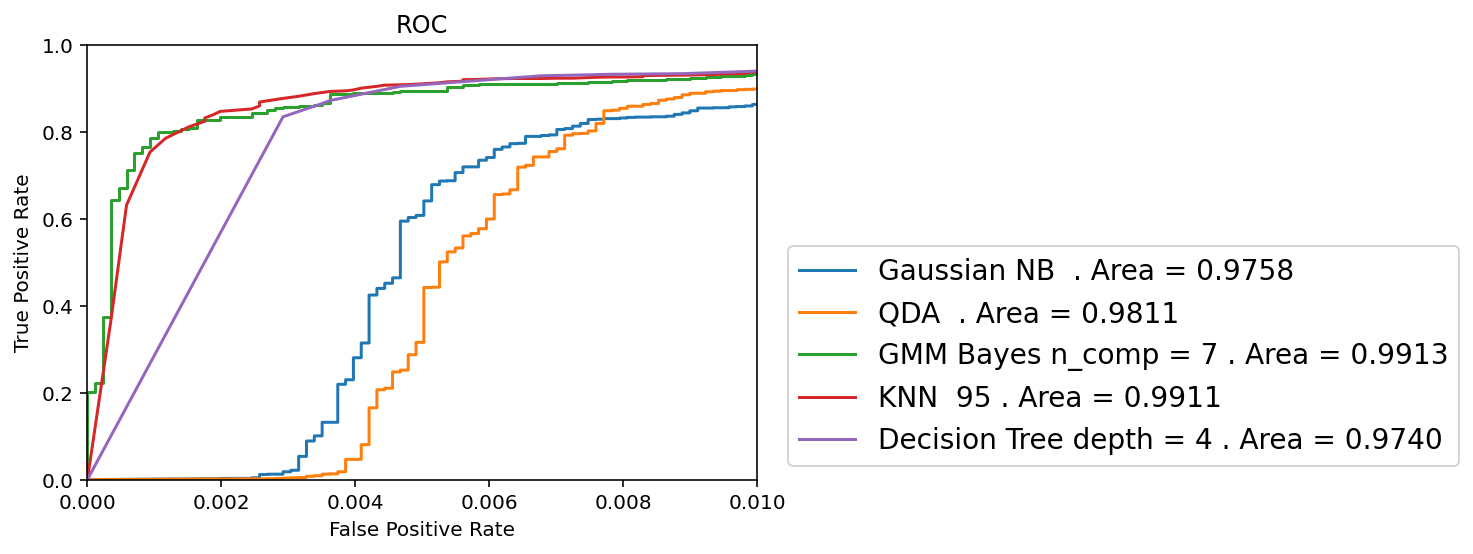

In [26]:
#Best pearmeters for GMMBayes , KNN, DT 
#More general code to get the best prameters for the different models , I think ideally a for loop would be nice if we wanted to add additional models


index_best_gmm_b = np.where(area_gmm_b == area_gmm_b.max())
index_best_NN = np.where(area_knn == area_knn.max())
index_best_dt = np.where(area_dt == area_dt.max())



best_n_comp = int(n_comp_array[index_best_gmm_b])
best_NN = int(NN[index_best_NN])
best_depth = int(tree_depth[index_best_dt])


# GNB - Gaussian Naive Bayes
GN_Bayes = GaussianNB() # model
GN_Bayes.fit(X_train_color, y_train_color) #training data 
y_pred_BN_Bayes = GN_Bayes.predict_proba(X_test_color)
q_prob_BN_Bayes = y_pred_BN_Bayes[:,1]
    
fpr_GN_Bayes, tpr_GN_Bayes, threshold_GN_Bayes = roc_curve(y_test_color, q_prob_BN_Bayes)
area_under_roc_GN_Bayes=trapz(y=tpr_GN_Bayes,x=fpr_GN_Bayes)
plt.plot(fpr_GN_Bayes,tpr_GN_Bayes, label= 'Gaussian NB ' + ' . Area = {:.4f}'.format(area_under_roc_GN_Bayes))
    
    

# QDA - QuadraticDiscriminantAnalysis
qda_model = QuadraticDiscriminantAnalysis() # model
qda_model.fit(X_train_color, y_train_color) #training data 
y_pred_qda = qda_model.predict_proba(X_test_color)
q_prob_qda = y_pred_qda[:,1]
    
fpr_qda, tpr_qda, threshold_qda = roc_curve(y_test_color, q_prob_qda)
area_under_roc_qda=trapz(y=tpr_qda,x=fpr_qda)
plt.plot(fpr_qda,tpr_qda, label= 'QDA ' + ' . Area = {:.4f}'.format(area_under_roc_qda))
   
    
#GMMBayes
GMM_B_model = GMMBayes(n_components=best_n_comp)
GMM_B_model.fit(X_train_color, y_train_color)
y_pred_color_GMM_B = GMM_B_model.predict_proba(X_test_color)
q_prob_color_GMM_B = y_pred_color_GMM_B[:,1]
    
fpr_GMM_B, tpr_GMM_B, threshold_GMM_B = roc_curve(y_test_color, q_prob_color_GMM_B)
area_under_roc_GMM_B=trapz(y=tpr_GMM_B,x=fpr_GMM_B)
plt.plot(fpr_GMM_B, tpr_GMM_B, label= 'GMM Bayes n_comp = ' + str(best_n_comp) + ' . Area = {:.4f}'.format(area_under_roc_GMM_B))

  
#K Nearest Neighbors
knn = KNN(best_NN)  
knn.fit(X_train_color, y_train_color)  
y_pred_color_knn = knn.predict_proba(X_test_color) 
q_prob_color_knn = y_pred_color_knn[:,1]
    
fpr_knn, tpr_knn, threshold_knn = roc_curve(y_test_color, q_prob_color_knn)
area_under_roc_knn=trapz(y=tpr_knn,x=fpr_knn)
plt.plot(fpr_knn, tpr_knn, label= 'KNN  ' + str(best_NN) + ' . Area = {:.4f}'.format(area_under_roc_knn))


#Decision Tree
d_tree_model = DT(max_depth=best_depth)  
d_tree_model.fit(X_train_color, y_train_color)  
y_pred_color_d_tree = d_tree_model.predict_proba(X_test_color) 
q_prob_color_d_tree = y_pred_color_d_tree[:,1]
    
fpr_dt, tpr_dt, threshold_dt = roc_curve(y_test_color, q_prob_color_d_tree)
area_under_roc_dt=trapz(y=tpr_dt,x=fpr_dt)
plt.plot(fpr_dt,tpr_dt, label= 'Decision Tree depth = {:.0f}'.format(best_depth) + ' . Area = {:.4f}'.format(area_under_roc_dt))

plt.axis([0,0.01,0,1])
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', bbox_to_anchor=(2.07, 0), fontsize=14)


The best performing classifier is KNN, with the largest ROC area 

10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

[Text(1, 0, 'GALAXY'), Text(1, 0, 'QSO')]

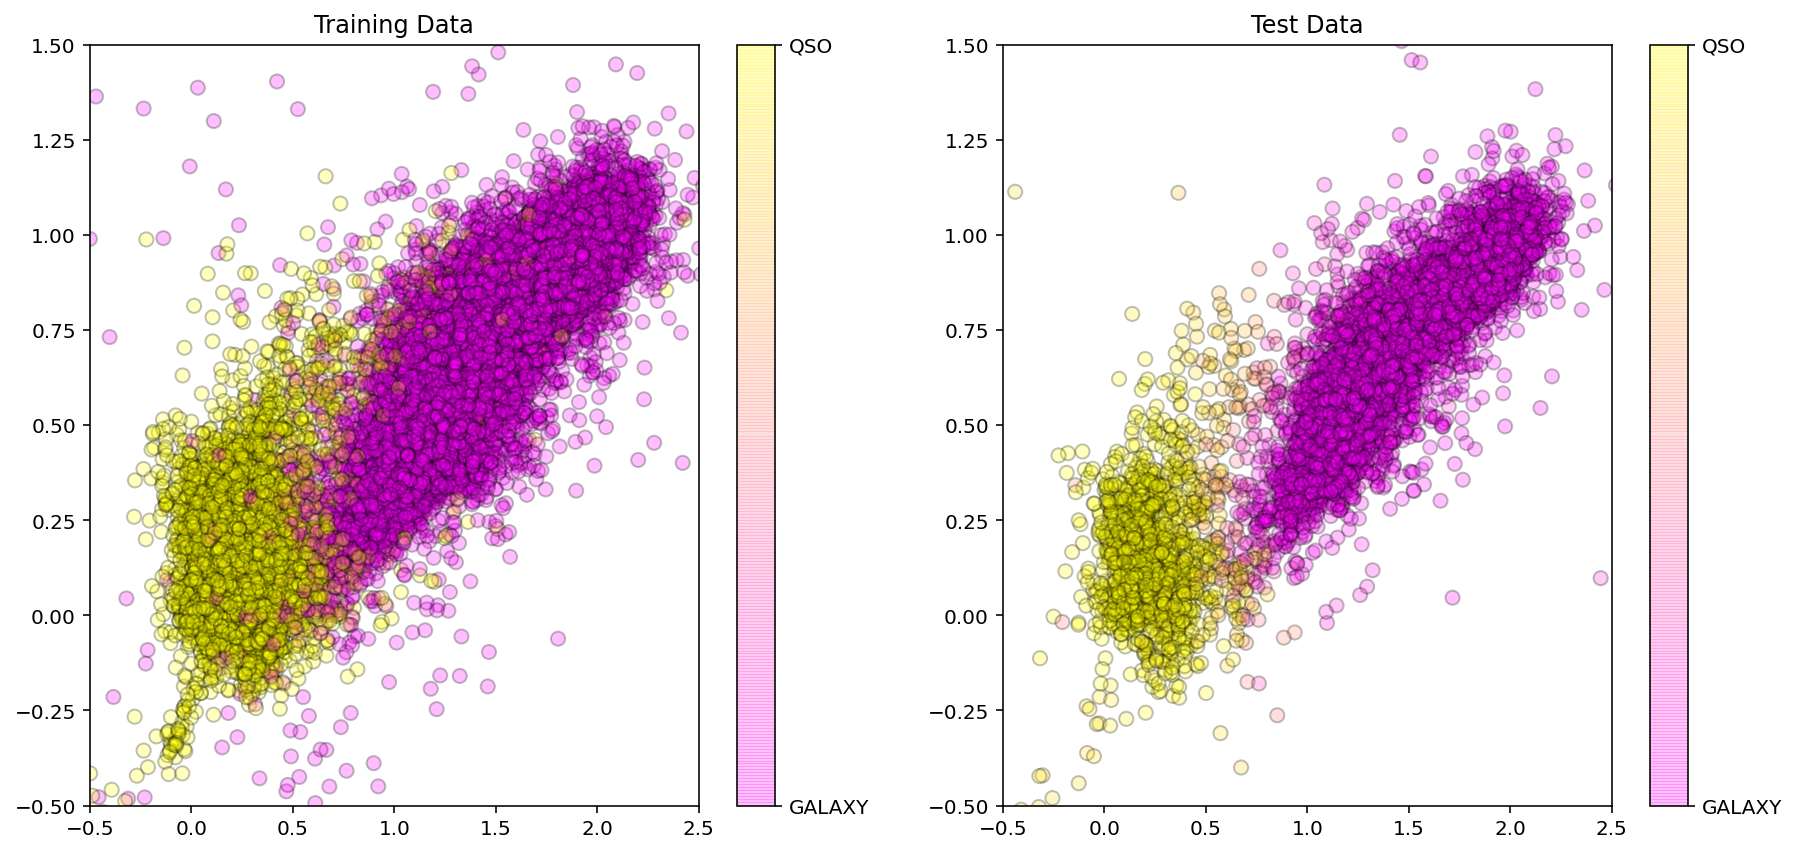

In [27]:
fig = plt.figure(figsize=(15,7))
training_data_plot = fig.add_subplot(121)
im2 = training_data_plot.scatter(X_train_color[:,0],  X_train_color[:,1],
         c = y_train_color, s=50, cmap='spring' ,edgecolor='k' , alpha = 0.25)

training_data_plot.set_xlim([-0.5, 2.5])
training_data_plot.set_ylim([-0.5, 1.5])
#training_data_plot.legend(loc='lower right')
training_data_plot.set_title('Training Data')


cbar = fig.colorbar(im2, ax =training_data_plot, ticks=[0, 1])
cbar.ax.set_yticklabels(['GALAXY', 'QSO'])  # vertically oriented colorbar

knn = KNN(best_NN)  
knn.fit(X_train_color, y_train_color)  
y_pred_color_knn = knn.predict_proba(X_test_color) 
    

test_data_plot = fig.add_subplot(122)

#cmap=plt.cm.spring
#norm = matplotlib.colors.BoundaryNorm(np.arange(0,2,1), cmap.N)

im=test_data_plot.scatter(X_test_color[:,0],  X_test_color[:,1],
         c = y_pred_color_knn[:,1], s=50, cmap='spring', edgecolor='k' , alpha = 0.25 )

test_data_plot.set_xlim([-0.5, 2.5])
test_data_plot.set_ylim([-0.5, 1.5])
#plt.legend(loc='lower right')
test_data_plot.set_title('Test Data')
#fig.colorbar(plot)

cbar = fig.colorbar(im, ax =test_data_plot, ticks=[0, 1])
cbar.ax.set_yticklabels(['GALAXY', 'QSO'])  




In [28]:
y_pred_color_knn.shape

(10000, 2)

In [29]:
X_test_color.shape

(10000, 4)

In [30]:
int(best_NN)

95